# Activity Recognition with Healthy Older People Using a Batteryless Wearable Sensor

This notebook provides code for loading the [activity recognition dataset](https://archive.ics.uci.edu/dataset/427/activity+recognition+with+healthy+older+people+using+a+batteryless+wearable+sensor) into a suitable format for classification and sequence labelling. 

The code is divided into three sections:
* Loading the data
* Sequence labelling: processing the data into a suitable format for sequence labelling. 
* Classification: processing the data into a suitable format for use with an IID classifier.

We recommend running all three sections, then using the variables produced by the code as required for sequence labelling and IID classification.


## Loading the Data

Run the following cells to load the data from disk. You will need to run code from the subsequent sections (or your own code) to get the data into a suitable format for classification and sequence labelling.  

In [1]:
import os

data_path = "activity_recognition_dataset/S1_Dataset"

files = os.listdir(data_path)
print(files)

['d1p01M', 'd1p02M', 'd1p03M', 'd1p04M', 'd1p05M', 'd1p06M', 'd1p07M', 'd1p08F', 'd1p09F', 'd1p10F', 'd1p11F', 'd1p12F', 'd1p13F', 'd1p14F', 'd1p15F', 'd1p16F', 'd1p17F', 'd1p18F', 'd1p19F', 'd1p20F', 'd1p21F', 'd1p22F', 'd1p23F', 'd1p24F', 'd1p25F', 'd1p26F', 'd1p27F', 'd1p28F', 'd1p29F', 'd1p30F', 'd1p31F', 'd1p32F', 'd1p33F', 'd1p34F', 'd1p35F', 'd1p36M', 'd1p37M', 'd1p38M', 'd1p39M', 'd1p40M', 'd1p41M', 'd1p42M', 'd1p43M', 'd1p44M', 'd1p45M', 'd1p46M', 'd1p47M', 'd1p48M', 'd1p49F', 'd1p50F', 'd1p51F', 'd1p52F', 'd1p53F', 'd1p54F', 'd1p55F', 'd1p56F', 'd1p57F', 'd1p58F', 'd1p59F', 'd1p60F', 'README.txt']


In [2]:
import pandas as pd  # use pandas to load data from CSV files

combined_data = []

for file in files:
    
    if file == "README.txt":
        continue
    
    try:
        # load a single sequence from the file
        seq_dataframe = pd.read_csv(os.path.join(data_path, file), header=None, names=["time", "frontal acc", "vertical acc", "lateral acc", "antenna ID", "RSSI", "phase", "frequency", "label"])
        
        # put the ID of the sequence into the dataframe as an extra column
        seq_dataframe['seqID'] = file  # use filename as ID
                
        combined_data.append(seq_dataframe)  # put the data frame into a list
    except:
        print(f"Could not load file {file}. Skipping.")

## Sequence Labelling

The following cell creates two variables that you can use for sequence labelling:
* X_by_seq is a list of 2-D numpy arrays. Each numpy array in this list corresponds to on data sequence and contains the input feature values for that sequence.
* y_by_seq is a list of 1-D numpy arrays, where each array contains the target class labels for each sequence. 

In [3]:
import numpy as np

# the pandas dataframe stores data in a table with headers
input_cols = ["frontal acc", "vertical acc", "lateral acc", "RSSI", "phase", "frequency"]  # column headers for the input features
output_col = "label"  # column header for the output label

# get the relevant columns from the pandas dataframes and convert to numpy arrays
X_by_seq = []  # store a list of numpy arrays containing the input features for each sequence
y_by_seq = []  # store a list of 1-D numpy arrays containing the target activity labels for each sequence

for seq_table in combined_data:
    X_by_seq.append(seq_table[input_cols].values)
    y_by_seq.append(seq_table[output_col].values - 1)    # subtract one from the label so that labels start from 0
    
n_states = np.unique(np.concatenate(y_by_seq)).size  # how many classes/states are there?

### Variables for sequence labelling

The cell below produces the data you need for sequence labelling... You should be able to work with these variables directly.

In [4]:
from sklearn.model_selection import train_test_split

# create train/test split. Sequences are kept complete.
X_by_seq_tr, X_by_seq_test, y_by_seq_tr, y_by_seq_test = train_test_split(X_by_seq, y_by_seq, test_size=0.2, random_state=21)  # You may wish to make further splits of the data or to modify this split.

You may find the following code useful for creating a sequence labelling model:

In [5]:
# Record which observations occur given each state (activity label)
X_given_y = [[] for _ in range(n_states)]  # empty list where we will record the observations that occur given each activity label

for s, X_seq in enumerate(X_by_seq_tr):
    for i in range(X_seq.shape[0]):
        state_i = y_by_seq_tr[s][i]
        X_given_y[state_i].append(X_seq[i, :][None, :])

In [6]:
from hmmlearn import hmm  # We recommend using this class if builing an HMM

# Record the mean feature values for observations in each state
means = np.zeros((n_states, len(input_cols)))

# Record the variance of feature values for observations in each state
diagonal_covars = np.zeros((n_states, len(input_cols)))

for state in range(n_states):
    means[state] = np.mean(X_given_y[state], axis=0)
    diagonal_covars[state, :] = np.var(X_given_y[state], axis=0)

## IID Classification

In this code, we take the X and y lists produced for sequence labelling, and concatenate the data points for all sequences. This produces a single set of training data and a single set of test data, which are not divided into separate sequences.  

In [7]:
X_tr = np.concatenate(X_by_seq_tr, axis=0)  # combine features into one matrix -- use this as input features for training a classifier
y_tr = np.concatenate(y_by_seq_tr)  # combine target labels into one list -- use this as target labels for training a classifier

In [8]:
X_test = np.concatenate(X_by_seq_test, axis=0)  # combine features into one matrix -- use this as input features for testing a classifier
y_test = np.concatenate(y_by_seq_test)  # combine target labels into one list -- use this as target labels for evaluating a classifier

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import log_loss
from sklearn.model_selection import ValidationCurveDisplay
from sklearn.model_selection import validation_curve
from sklearn.model_selection import LearningCurveDisplay
from sklearn.model_selection import learning_curve

In [10]:
from sklearn.preprocessing import StandardScaler

# Standardize X_tr and X_test
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_test_scaled = scaler.transform(X_test)

Text(0.5, 1.0, 'Learning Curve for MLPClassifier')

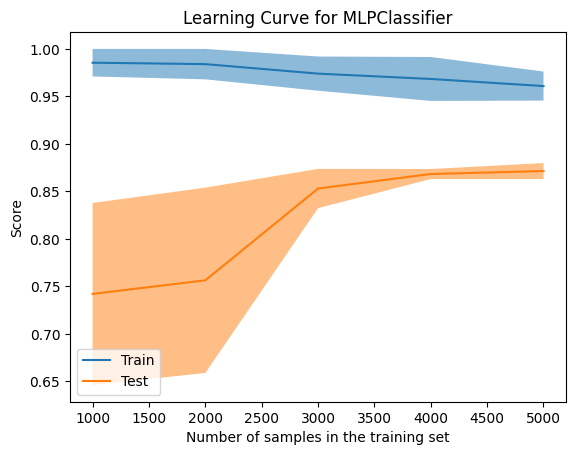

In [11]:
disp = LearningCurveDisplay.from_estimator(
    MLPClassifier(max_iter=1000, random_state=42),
    X_tr_scaled,
    y_tr,
    cv=2,
    n_jobs=-1,
    train_sizes=[1000,2000,3000,4000,5000],
)
disp.ax_.set_title('Learning Curve for MLPClassifier')

In [12]:
train_sizes, train_scores, valid_scores = learning_curve(
    MLPClassifier(max_iter=1000, random_state=42),
    X_tr_scaled,
    y_tr,
    cv=2,
    n_jobs=-1,
    train_sizes=[1000,2000,3000,4000,5000],
);

In [13]:
print(f"Mean training score:\n{round(np.mean(train_scores),2)}")
print(f"Mean validation score:\n{round(np.mean(valid_scores),2)}")

Mean training score:
0.97
Mean validation score:
0.82


In [14]:
parameters = {
    'hidden_layer_sizes': [32, 64, 128],
    'multiple_hidden_layer_sizes': [(100,), (100,100), (100,100,100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10],
    'n_iter_no_change': [10, 20, 30, 40, 50],
}

In [15]:
# Create an instance of the classifier
classifier = MLPClassifier(max_iter=1000, random_state=42)

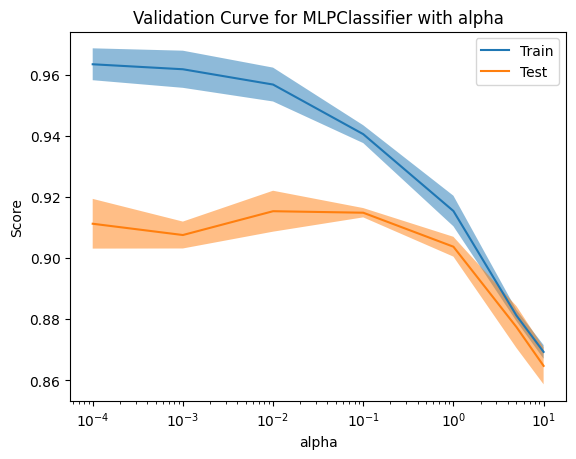

In [16]:
disp = ValidationCurveDisplay.from_estimator(
    classifier,
    X_tr_scaled,
    y_tr,
    param_name='alpha',
    param_range=parameters['alpha'],
    cv=2,
    n_jobs=-1
).ax_.set_title('Validation Curve for MLPClassifier with alpha')


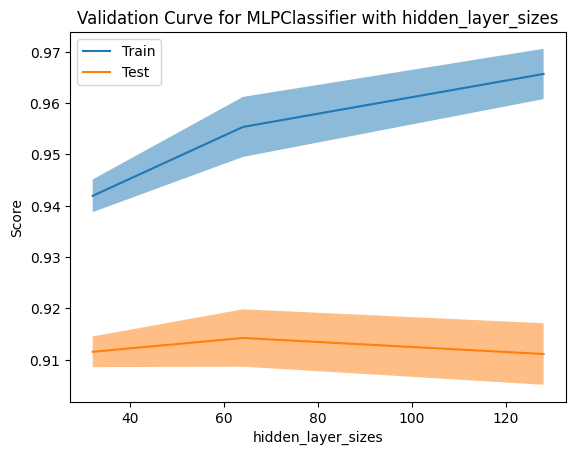

In [17]:
disp = ValidationCurveDisplay.from_estimator(
    classifier,
    X_tr_scaled,
    y_tr,
    param_name='hidden_layer_sizes',
    param_range=parameters['hidden_layer_sizes'],
    cv=2,
    n_jobs=-1
).ax_.set_title('Validation Curve for MLPClassifier with hidden_layer_sizes')

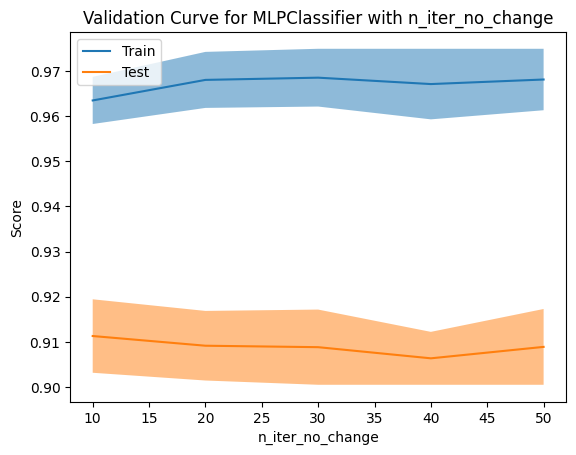

In [18]:
disp = ValidationCurveDisplay.from_estimator(
    classifier,
    X_tr_scaled,
    y_tr,
    param_name='n_iter_no_change',
    param_range=parameters['n_iter_no_change'],
    cv=2,
    n_jobs=-1
).ax_.set_title('Validation Curve for MLPClassifier with n_iter_no_change')


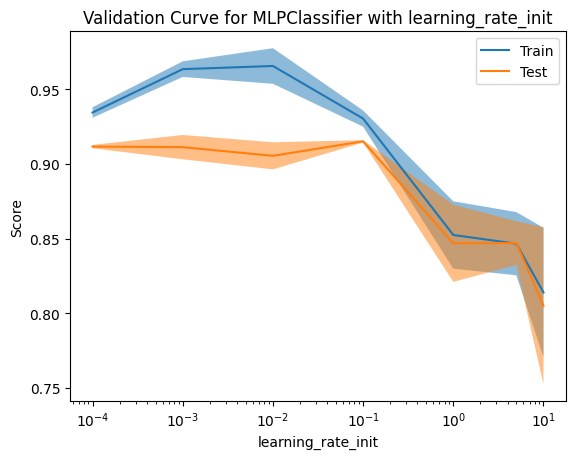

In [19]:
disp = ValidationCurveDisplay.from_estimator(
    classifier,
    X_tr_scaled,
    y_tr,
    param_name='learning_rate_init',
    param_range=parameters['learning_rate_init'],
    cv=2,
    n_jobs=-1
).ax_.set_title('Validation Curve for MLPClassifier with learning_rate_init')


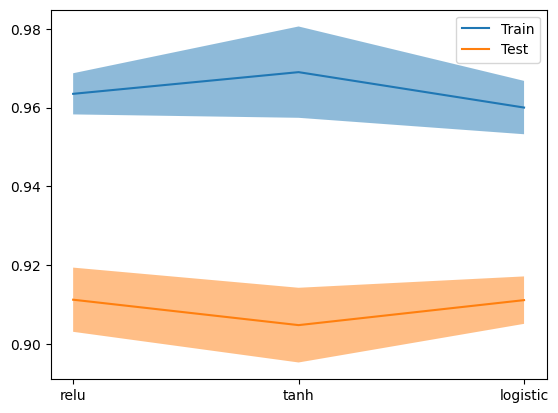

In [20]:
# Exception for worded parameters
try:
    disp = ValidationCurveDisplay.from_estimator(
        classifier,
        X_tr_scaled,
        y_tr,
        param_name='activation',
        param_range=parameters['activation'],
        cv=2,
        n_jobs=-1
    ).ax_.set_title('Validation Curve for MLPClassifier with activation')
except np.core._exceptions.UFuncTypeError:
    pass

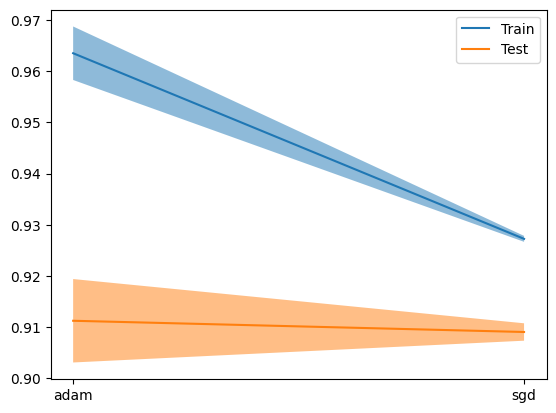

In [21]:
try:
    disp = ValidationCurveDisplay.from_estimator(
        classifier,
        X_tr_scaled,
        y_tr,
        param_name='solver',
        param_range=parameters['solver'],
        cv=2,
        n_jobs=-1
    ).ax_.set_title('Validation Curve for MLPClassifier with solver')

except np.core._exceptions.UFuncTypeError:
    pass


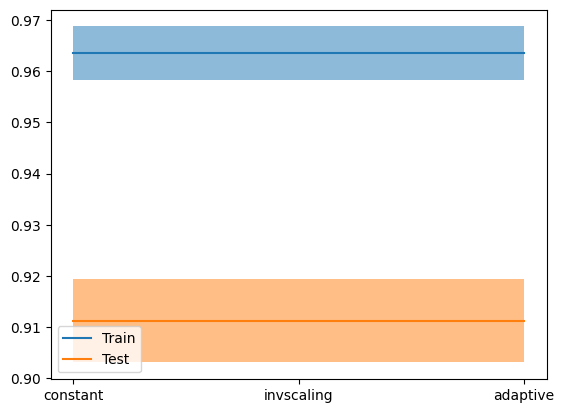

In [22]:
try:
    disp = ValidationCurveDisplay.from_estimator(
        classifier,
        X_tr_scaled,
        y_tr,
        param_name='learning_rate',
        param_range=parameters['learning_rate'],
        cv=2,
        n_jobs=-1
    ).ax_.set_title('Validation Curve for MLPClassifier with learning_rate')

except np.core._exceptions.UFuncTypeError:
    pass
